In [1]:
import time
import copy
import matplotlib.pyplot as plt
import os

import torch
from vit_pytorch.cct import CCT
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from UnityDataset import CustomData
from lion_pytorch import Lion
import torchvision.models

torch.manual_seed(17)

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomRotation(8, interpolation=Image.BILINEAR),
    transforms.ToTensor()
])

In [3]:
dataset_path = "S:\datasets\solo250kv2"
dataset = CustomData(dataset_path, transform=transform, save=True)

Loaded filenames and positions from JSON file.
finished setting up dataset
Items in dataset: 250000


In [4]:
train_data, val_data = torch.utils.data.random_split(dataset, [225000, 25000])

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=8)

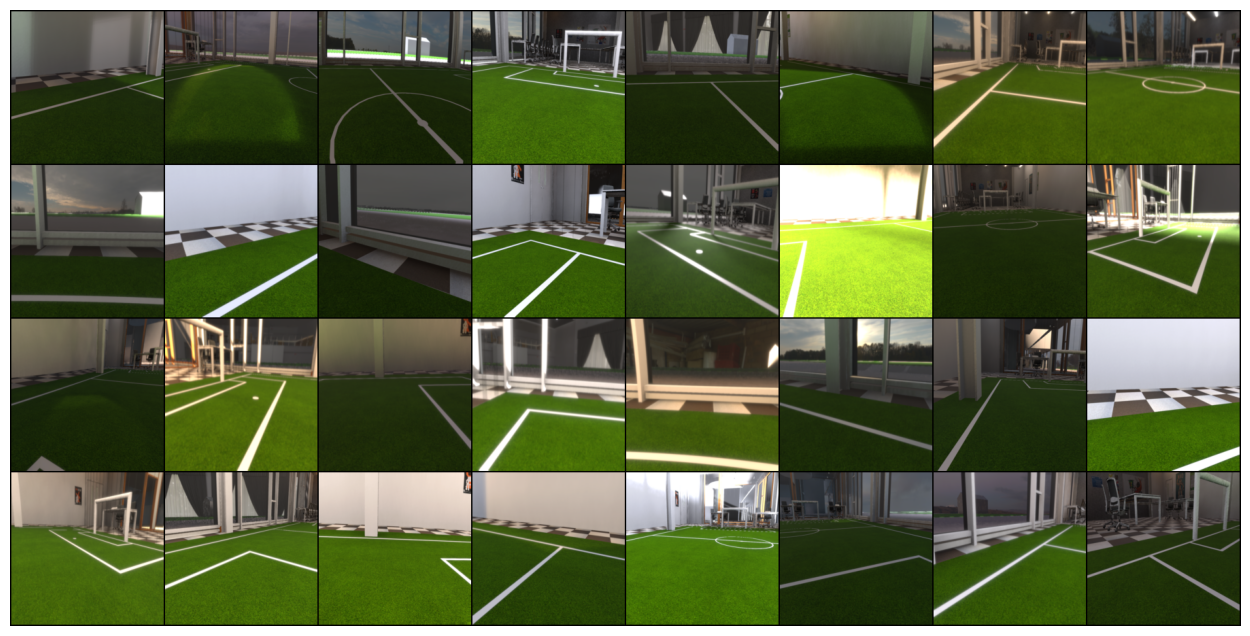

In [5]:
from torchvision.utils import make_grid

for images, _ in train_loader:
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(make_grid(images[:32], nrow=8).permute((1, 2, 0)))
    break

In [6]:
model = torchvision.models.resnet50()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
model.to(device)
next(model.parameters()).is_cuda

True

In [9]:
epochs = 50 #50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
# optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, use_auxiliary=True):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    with open(f'vit_cct{dataset.captures}loss.txt', 'w') as f:

        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            for phase in ['train', 'val']: # Each epoch has a training and validation phase
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]: # Iterate over data
                    inputs = inputs.to(device)

                    labels = labels.to(device)

                    optimizer.zero_grad() # Zero the parameter gradients

                    with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train
                        if phase == 'train': # Backward + optimize only if in training phase
                            if use_auxiliary:
                                outputs = model(inputs)
                                loss = criterion(outputs, labels)
                            else:
                                outputs = model(inputs)
                                loss = criterion(outputs, labels)

                            _, preds = torch.max(outputs, 1)
                            loss.backward()
                            optimizer.step()

                        if phase == 'val':
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            _, preds = torch.max(outputs, 1)

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)

                if phase == 'val': # Adjust learning rate based on val loss
                    lr_scheduler.step(epoch_loss)

                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                f.write(f"{epoch_loss}, {epoch_acc}\n")

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val':
                    val_acc_history.append(epoch_acc)

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        f.close()
        return model, val_acc_history

In [11]:
model, _ = train_model(model, {"train": train_loader, "val": val_loader}, criterion, optimizer, epochs)
if os.name == 'nt':
    filename = "RESNET50_DATASET" + dataset_path.split("\\")[-1] + "EPOCHS" + str(epochs) + ".pt"
else:
    filename = "RESNET50_DATASET" + dataset_path.split("/")[-1] + "EPOCHS" + str(epochs) + ".pt"

# Save the trained model to a file.
torch.save(model.state_dict(), filename)

Epoch 0/49
----------


RuntimeError: GET was unable to find an engine to execute this computation